## Set up...

In [1]:
#Base libraries for interactive work
import numpy as np #We will make extensive use of Numpy arrays 
import multiprocessing as mp #Enable multiprocessing
from tqdm import tqdm_notebook #For monitoring process of big jobs
from astropy.io import fits #astropy modules for FITS IO

#Based libraries for iPython Plots
import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting of os/x
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images
import time as t
%matplotlib inline

import medfit  #Fortran backend for median fits (this is much faster and reliable than the python version)

import neossatlib as neo  #Main Python Libs for NEOSSat processing.  

def barupdate(result):
    pbar.update()

In [2]:
## For Debugging
#import importlib

In [3]:
## For Debugging
#importlib.reload(neo)  #Re-loading is for development purposes only - you don't need to run this. 

In [4]:
workdir='/data/NEOSSat/OBS/2018-211-WASP33/'  #Directory that contains FITS files
savedir="/data/NEOSSat/WASP-33/" #Directory to save cleaned images. 
fileslist='files_raw.list'     #Simple text file that contains the names of all the FITS files to process.  
bpix=-1.0e10                   #value to mark bad pixels. Any pixel *below* bpix is considered invalid.
sigscalel=1.0                  #low bounds for display clipping.  Keep small to keep background 'dark'
sigscaleh=1.0                  #high bounds for display clipping.
#--- Parameters for making a Dark image ---#
ilow=1                         #number of low value frames to reject when generating dark image
ihigh=1                        #number of high value frames to reject when generating dark image
##--- Centroiding Parameters ---#
#itermax=5                      #Maximum number of interations to update centroid
#dcoocon=0.1                    #Centroid position updated is converged when it changes by less than this value (pixels)
#ndp=3                          #half-length size of box to find centroid center. (box side has length 2*ndp)
#--- Parameters for photometry ---#
#sbox=10                        #simple half-length box for simple box-photometry. (box side has length 2*sbox)
magzero=20.                     #zero-point for instrumental magnitude
photap=6.0                      #photometric aperture
#--- Raster info ---#
xsc=512 #Size of science raster (light or dark)
ysc=512
xov=512 #Size of overscan.  xov must equal xsc
yov=60
#--- Parameters for Fourier Decomp. ---#
snrcut=10.0  #When to stop decomposition 
fmax=2 #Maximum number of frequencies in model
xoff=0 #pixel offsets 
yoff=0
T=8 #Oversampling
info=0 # 0 - no plots, no output, 1 - no plots, output, 2 - plots, output

imagefiles=neo.read_file_list(workdir+fileslist)

## Get list of Dark Images

In [5]:
darklist=[]
nfiles=len(imagefiles)
for i in range(nfiles):
    filename=workdir+imagefiles[i]
    hdulist = fits.open(filename)
    shutter=hdulist[0].header['SHUTTER']
    if int(shutter[0]) != 0:  #Check if shutter was open or closed.
        darklist.append(imagefiles[i])
    hdulist.close()
print("Number of dark images: ",len(darklist))

Number of dark images:  22


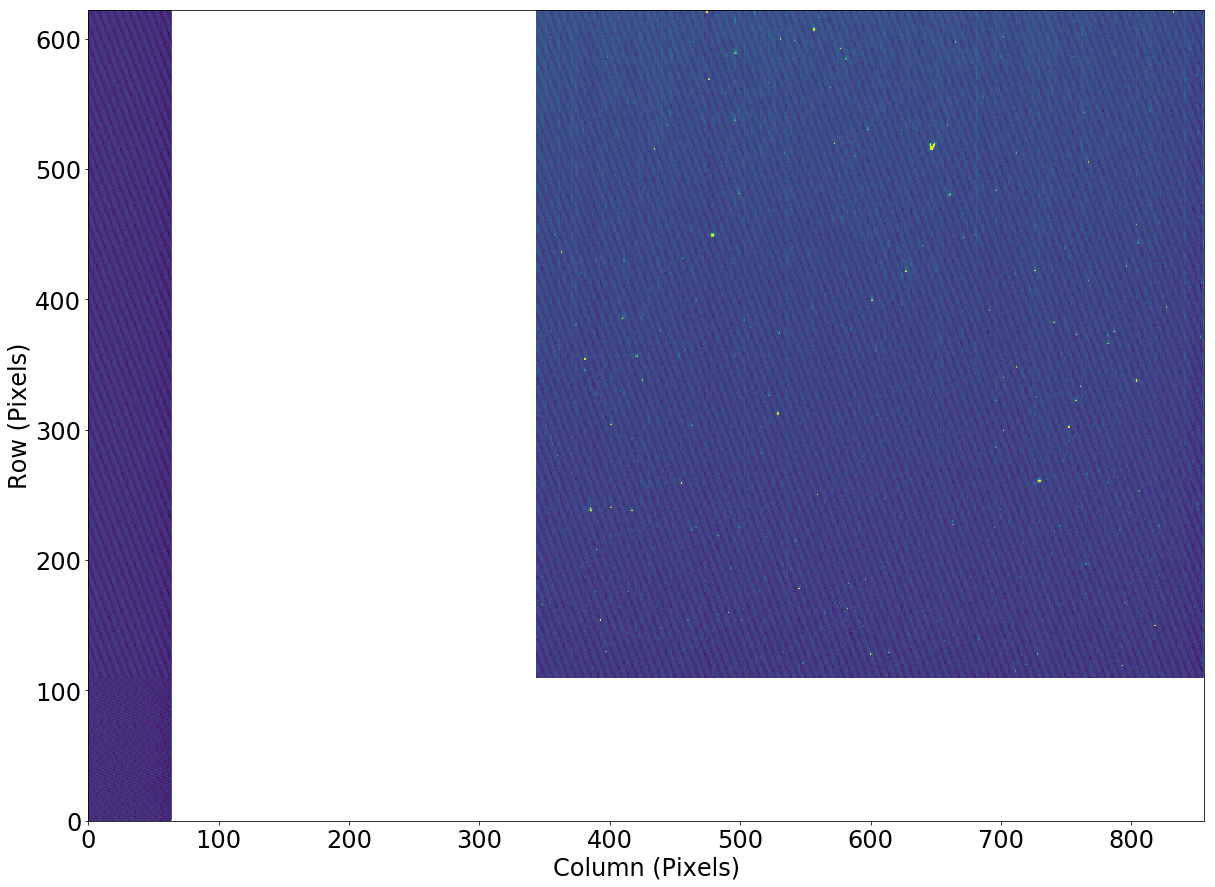

In [6]:
#Lets see an image to confirm settings are corrrect for overscan and science subrasters
image=neo.read_fitsdata(workdir+darklist[0])
imstat=neo.imagestat(image,bpix)
neo.plot_image(image,imstat,0.1,1.5)

## Process the Dark Images.  

Overscan and bias corrections are applied.

In [7]:
pbar = tqdm_notebook(total=len(darklist))  #Will make a progressbar to monitor processing.  
pool = mp.Pool(processes=24)  #Use lots of threads - because we can! 
results = [pool.apply_async(neo.darkprocess, args=(workdir,darkfile,xsc,ysc,xov,yov,snrcut,fmax,xoff,yoff,T,\
                bpix,),callback=barupdate) for darkfile in darklist]
alldarkdata = [p.get() for p in results]
pool.close()
pool.join()

In [8]:
## Tasks to clean up multiprocessing if it is aborted.  
#pool.close()
#pool.terminate()
#pool.join()

## Combine Darks  

Darks are scaled to match each other, then a median average is applied.  
 - **To do:** This should be moved to a function call to keep things clean

In [9]:
dscale=[]
dscale.append([0.0,1.0])
ndark=len(darklist)
for i in range(1,ndark):
    image1=alldarkdata[0]
    image2=alldarkdata[i]

    data1=image1.flatten()
    data2=image2.flatten()

    data1t=data1[(data1 > 200) & (data1 < 2000) & (data2 > 200) & (data2 < 2000)]
    data2t=data2[(data1 > 200) & (data1 < 2000) & (data2 > 200) & (data2 < 2000)]

    data1=np.copy(data1t)
    data2=np.copy(data2t)

    ndata=len(data1)
    if (ndata > 5) & (len(data2) > 5):
        abdev=1.0
        a,b = medfit.medfit(data1,data2,ndata,abdev)
        dscale.append([a,b])
    else:
        dscale.append([0,1])
    
darkavg=np.median([dscale[i][0]+dscale[i][1]*alldarkdata[i] for i in range(ndark)],axis=0)

## Display Master Dark

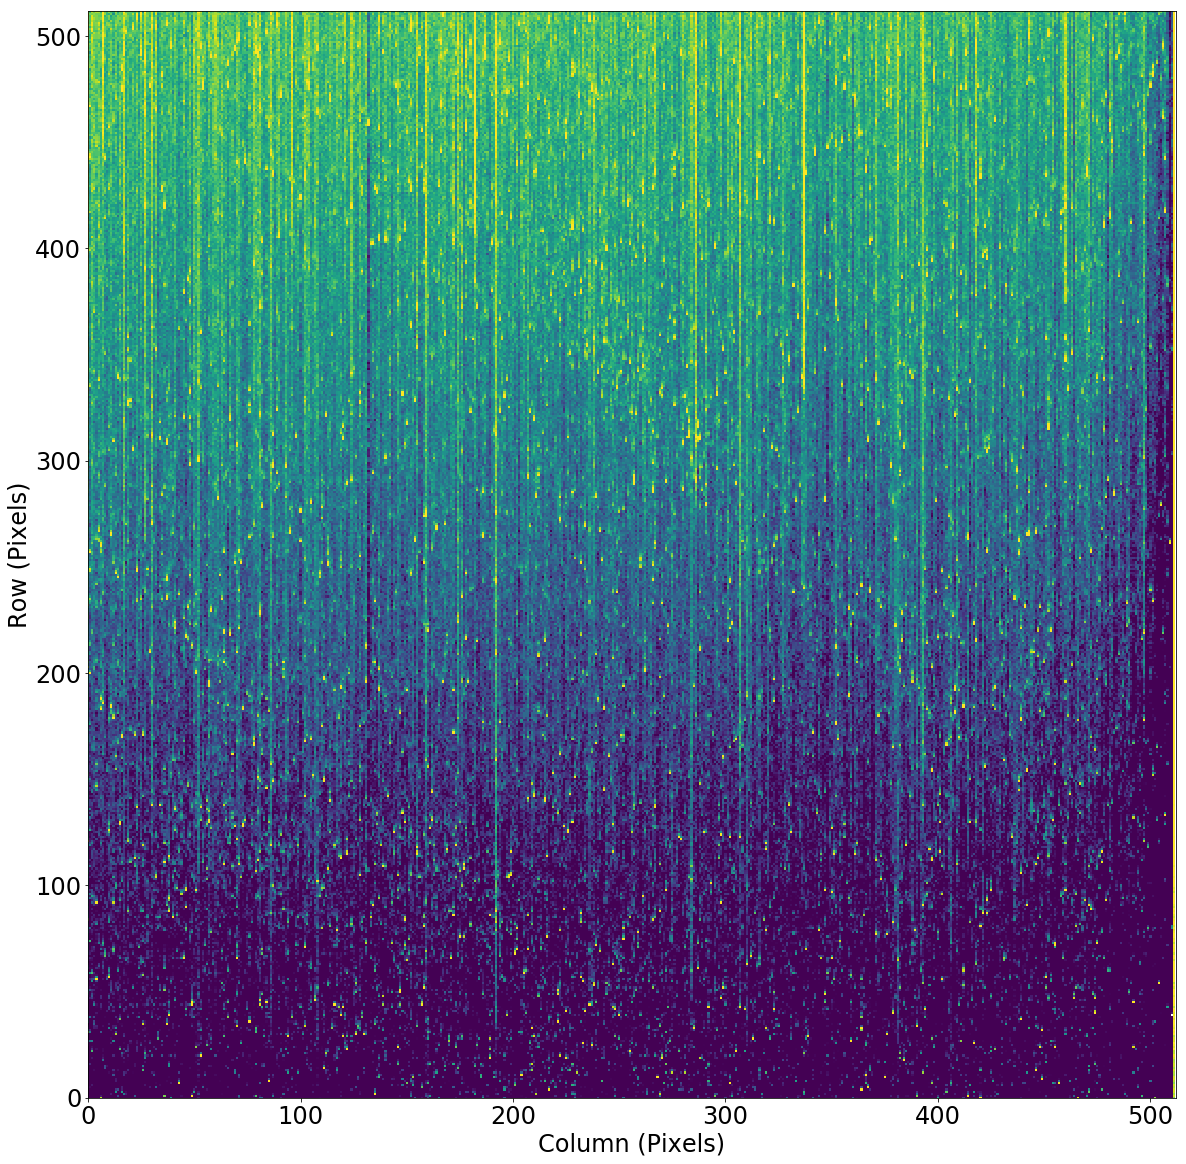

In [10]:
imstat=neo.imagestat(darkavg,bpix)
neo.plot_image(darkavg,imstat,1.0,3.0)

## If we are happy with the Master dark, then clean up workspace

In [11]:
alldarkdata = []

## Get List of Light Images

In [12]:
lightlist=[]
jddate=[]
exptime=[]
nfiles=len(imagefiles)
for i in range(nfiles):
    filename=workdir+imagefiles[i]
    hdulist = fits.open(filename)
    shutter=hdulist[0].header['SHUTTER']
    mode=hdulist[0].header['MODE']
    #print(mode[0:2],imagefiles[i])
    if (int(shutter[0]) == 0) & (int(mode[0:2]) == 16):  #Check if shutter was open or closed.
        lightlist.append(imagefiles[i])
        jddate.append(float(hdulist[0].header['JD-OBS']))
        exptime.append(float(hdulist[0].header['EXPOSURE']))
    hdulist.close()
jddate=np.array(jddate)
exptime=np.array(exptime)
print("number of images: ",len(lightlist))

number of images:  286


## Process a light Image  

Then plot it..

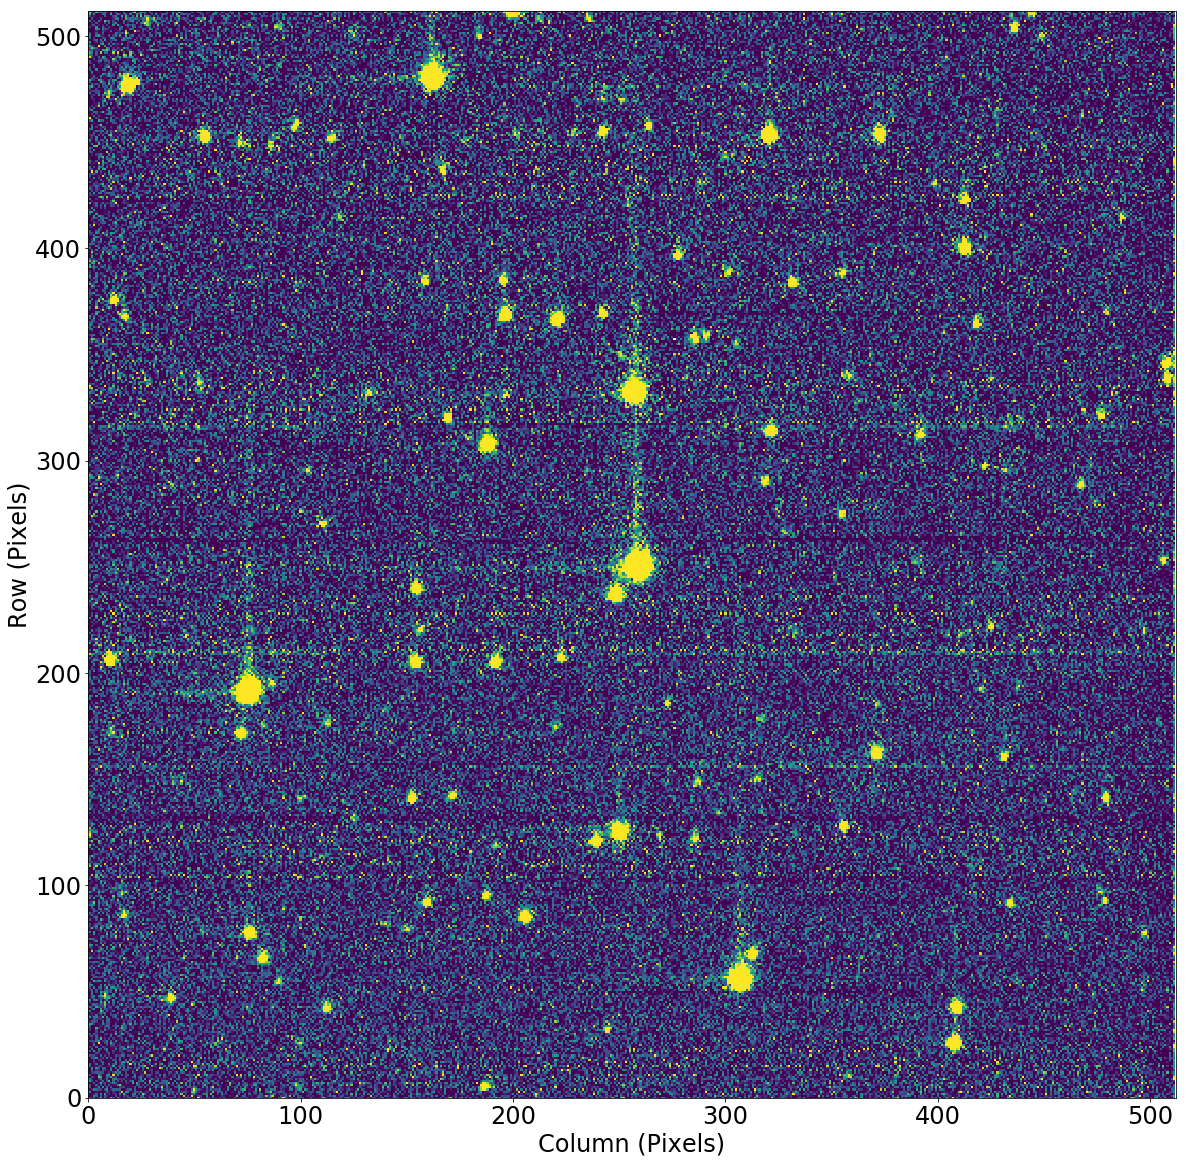

In [14]:
filename=workdir+lightlist[0]
scidata_cord=\
  neo.clean_sciimage(filename,darkavg,xsc,ysc,xov,yov,snrcut,fmax,xoff,yoff,T,info,bpix)

imstat=neo.imagestat(scidata_cord,bpix)
neo.plot_image(scidata_cord,imstat,0.3,3.0)

## Batch process and save cleaned images

In [15]:
pbar = tqdm_notebook(total=len(lightlist))  #Progress bar.
pool = mp.Pool(processes=24)  #How many threads to use.
results = [pool.apply_async(neo.lightprocess_save, args=(workdir+lightlist[i],savedir,darkavg,xsc,ysc,xov,yov,\
           snrcut,fmax,xoff,yoff,T,bpix,),callback=barupdate)\
           for i in range(len(lightlist))]
saveall = [p.get() for p in results]
pool.close()
pool.join()

In [16]:
print("All done..")

All done..


In [24]:
## Tasks to clean up multiprocessing if it is aborted.  
#pool.close()
#pool.terminate()
#pool.join()